In [73]:
import os
import time
import joblib
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.inspection import permutation_importance
from scipy.stats import randint, uniform, loguniform

pd.set_option('display.max_columns', None)
load_dotenv(override=True)

DB_URL = f"postgresql+psycopg2://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
engine = create_engine(DB_URL)

In [74]:
TABLE_NAME = "superstore_data_cleaned"
TARGET_COLUMN = "Response"

df = pd.read_sql(f"SELECT * FROM {TABLE_NAME}", engine)

# Encode columns
object_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if TARGET_COLUMN in object_cols:
    object_cols.remove(TARGET_COLUMN)
if object_cols:
    df = pd.get_dummies(df, columns=object_cols, drop_first=True)

X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

print(f"X shape: {X.shape}")

X shape: (2043, 24)


In [76]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(C=1e9, max_iter=5000, solver='lbfgs', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=300, learning_rate=0.2, max_depth=30, min_samples_leaf=1, random_state=42),
    "SVC": SVC(C=1e9, probability=True, gamma='scale', random_state=42)
}

scoring = ['precision', 'recall', 'f1', 'roc_auc']
results = []
timestamp = pd.Timestamp.now()

for name, model in models.items():
    print(f"Training: {name}")
    
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', model)])
    
    scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    mean_scores = {
        'model_name': name,
        'precision': np.mean(scores['test_precision']),
        'recall': np.mean(scores['test_recall']),
        'f1': np.mean(scores['test_f1']),
        'roc_auc': np.mean(scores['test_roc_auc']),
        'training_time': np.mean(scores['fit_time']),
        'created_at': timestamp,
        'source': 'train'}
    results.append(mean_scores)
    
    model_record = {
        'model_name': name,
        'source': 'train',
        'algorithm': model.__class__.__name__,
        'created_at': timestamp}

    pd.DataFrame([model_record]).to_sql('models',engine,if_exists='append',index=False)

# Saving metrics
metrics_df = pd.DataFrame(results)
metrics_df.to_sql('model_metrics', engine, if_exists='append', index=False)
display(metrics_df.sort_values(by='f1', ascending=False))

Training: Logistic Regression
Training: Random Forest
Training: Gradient Boosting
Training: SVC


,model_name,precision,recall,f1,roc_auc,training_time,created_at,source
0,Logistic Regression,0.379732,0.756531,0.505177,0.843559,0.063671,2026-01-13 14:23:42.825509,train
1,Random Forest,0.543567,0.370175,0.439369,0.836927,2.332724,2026-01-13 14:23:42.825509,train
3,SVC,0.422444,0.396034,0.407630,0.801339,2.189781,2026-01-13 14:23:42.825509,train
2,Gradient Boosting,0.379375,0.398995,0.387568,0.801731,56.253744,2026-01-13 14:23:42.825509,train



 Feature importance analysis 

Analyzing: Logistic Regression


C:\Users\user\AppData\Local\Temp\ipykernel_3396\2864137438.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, ax=axes[i], palette='viridis')


Analyzing: Random Forest


C:\Users\user\AppData\Local\Temp\ipykernel_3396\2864137438.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, ax=axes[i], palette='viridis')


Analyzing: Gradient Boosting


C:\Users\user\AppData\Local\Temp\ipykernel_3396\2864137438.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, ax=axes[i], palette='viridis')


Analyzing: SVC


C:\Users\user\AppData\Local\Temp\ipykernel_3396\2864137438.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, ax=axes[i], palette='viridis')


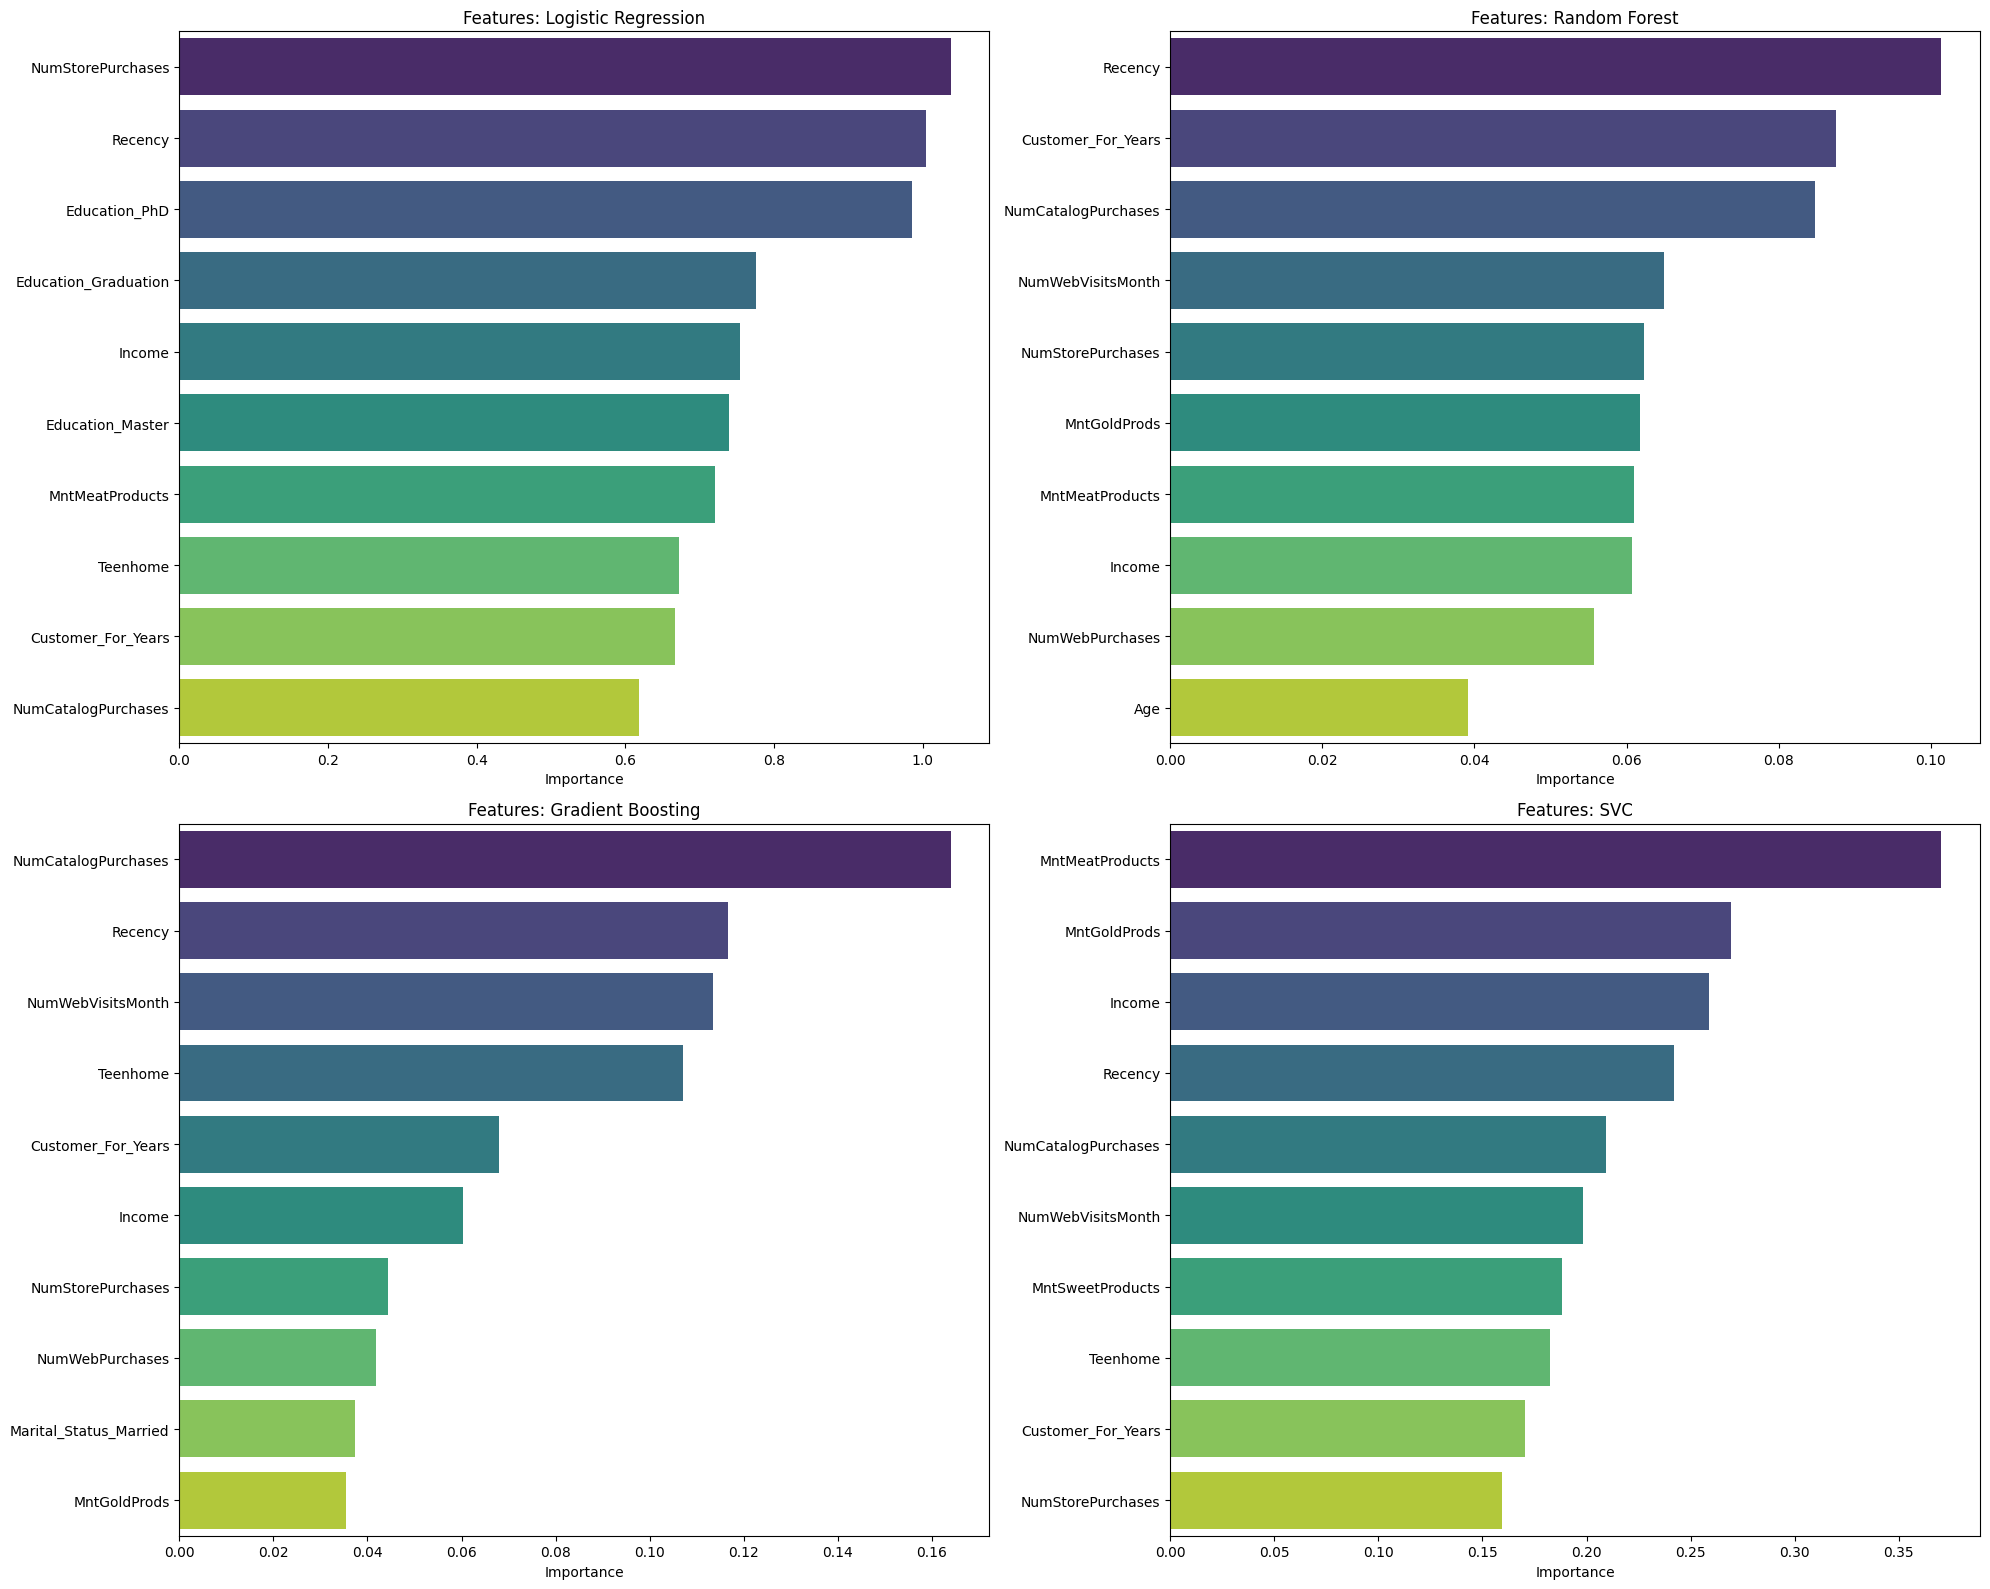

In [77]:
print("\n Feature importance analysis \n")
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    print(f"Analyzing: {name}")
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    pipeline.fit(X, y)
    trained_model = pipeline.named_steps['classifier']
    feature_names = X.columns
    importances = None
    
    # Random Forest, Gradient Boosting
    if hasattr(trained_model, 'feature_importances_'):
        importances = trained_model.feature_importances_
    # Logistic Regression
    elif hasattr(trained_model, 'coef_'):
        importances = np.abs(trained_model.coef_[0])
    # SVC 
    else:
        perm_result = permutation_importance(pipeline, X, y, n_repeats=5, random_state=42, n_jobs=-1, scoring='f1')
        importances = perm_result.importances_mean

    feat_imp_df = pd.DataFrame({'Feature': feature_names,'Importance': importances})
    feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(10)
    sns.barplot(x='Importance', y='Feature', data=feat_imp_df, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Features: {name}')
    axes[i].set_xlabel('Importance')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

In [68]:
# Selecting the best model based on F1 score
best_initial_row = metrics_df.sort_values(by='f1', ascending=False).iloc[0]
best_model_name = best_initial_row['model_name']
print(f"Best baseline model selected for tuning: {best_model_name} (F1: {best_initial_row['f1']:.4f})")

base_estimator = clone(models[best_model_name])

all_param_dists = {
    "Logistic Regression": {'model__C': loguniform(0.1, 10000), 'model__solver': ['liblinear', 'lbfgs']},
    
    "Random Forest": {
        'model__n_estimators': randint(100, 500),       
        'model__max_depth': randint(10, 50),           
        'model__min_samples_leaf': randint(1, 10),     
        'model__min_samples_split': randint(2, 20)},
    
    "Gradient Boosting": {
        'model__n_estimators': randint(100, 400),
        'model__learning_rate': uniform(0.01, 0.3),      
        'model__max_depth': randint(3, 15),              
        'model__min_samples_leaf': randint(1, 10),
        'model__subsample': uniform(0.7, 0.3)},
    
    "SVC": {'model__C': loguniform(1, 1000), 'model__gamma': ['scale', 'auto'], 'model__kernel': ['rbf']}
}

current_param_dist = all_param_dists[best_model_name]

pipeline_tune = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', base_estimator)
])

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline_tune, 
    param_distributions=current_param_dist, 
    n_iter=50,           
    cv=3, 
    scoring='f1', 
    n_jobs=-1, 
    verbose=1,
    random_state=42
)

random_search.fit(X, y)
print(f"Best F1 score: {random_search.best_score_:.4f}")
best_model = random_search.best_estimator_

# Saving
if not os.path.exists("models"):
    os.makedirs("models")

safe_model_name = best_model_name.replace(" ", "_")
filename = f"models/best_{safe_model_name}_optimized_{pd.Timestamp.now().strftime('%Y%m%d_%H%M')}.pkl"
joblib.dump(best_model, filename)

y_pred = best_model.predict(X)
try:
    y_prob = best_model.predict_proba(X)[:, 1]
    auc_score = roc_auc_score(y, y_prob)
except:
    y_prob = None
    auc_score = 0.0

final_metrics = {
    'model_name': f"{best_model_name} (Opt.)",
    'precision': precision_score(y, y_pred),
    'recall': recall_score(y, y_pred),
    'f1': f1_score(y, y_pred),
    'roc_auc': auc_score,
    'training_time': random_search.refit_time_,
    'created_at': pd.Timestamp.now(),
    'source': f"optimized"
}

final_model = {
    'model_name': f"{best_model_name} (Opt.)",
    'source': 'optimized',
    'algorithm': best_model.__class__.__name__,
    'created_at': pd.Timestamp.now()
}

pd.DataFrame([final_model]).to_sql('models', engine, if_exists='append', index=False)
pd.DataFrame([final_metrics]).to_sql('model_metrics', engine, if_exists='append', index=False)
display(pd.DataFrame([final_metrics]))

Best baseline model selected for tuning: Logistic Regression (F1: 0.5052)
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best F1 score: 0.3683


,model_name,precision,recall,f1,roc_auc,training_time,created_at,source
0,Logistic Regression (Opt.),0.390048,0.788961,0.522019,0.859567,0.069902,2026-01-13 14:13:31.978236,optimized
